In [23]:
from math import sqrt
import numpy as np
import pandas as pd

from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import keras


In [24]:
# 使用前400个点的 speed & power 预测接下来 4h(4h/15min) 的power
n_back = 400
n_out = 16
n_pre = n_out*15*2
n_feature = 2
# 使用前10天的数据进行训练  #训练天数过少可能会导致过拟合
train_len = 10
# 神经网络参数
units = 100
rounds = 100
size = 72

In [25]:
dataset = pd.read_csv("C:/Users/24496/Desktop/BigData/wind_preprocessed.csv", header=0, index_col=0).query('day<14')
dataset

,power,speed,date.1,day,hour,minute,second,speed_moveavg,power_moveavg,speed_savgol_filter,power_savgol_filter
date,,,,,,,,,,,
2015-10-01 00:00:00,0.38065,0.39627,2015-10-01 00:00:00,1,0,0,0,0.39627,0.38065,0.39630,0.37963
2015-10-01 00:00:30,0.36943,0.39592,2015-10-01 00:00:30,1,0,0,30,0.39592,0.36943,0.39580,0.37350
2015-10-01 00:01:00,0.38529,0.39538,2015-10-01 00:01:00,1,0,1,0,0.39538,0.38529,0.39555,0.37919
2015-10-01 00:01:30,0.38892,0.39579,2015-10-01 00:01:30,1,0,1,30,0.39579,0.38892,0.39555,0.39443
2015-10-01 00:02:00,0.41220,0.39627,2015-10-01 00:02:00,1,0,2,0,0.39627,0.41220,0.39670,0.41116
...,...,...,...,...,...,...,...,...,...,...,...
2015-10-13 23:57:30,0.19256,0.34645,2015-10-13 23:57:30,13,23,57,30,0.34645,0.19256,0.34587,0.19193
2015-10-13 23:58:00,0.19485,0.34559,2015-10-13 23:58:00,13,23,58,0,0.34559,0.19485,0.34594,0.19456
2015-10-13 23:58:30,0.19554,0.34562,2015-10-13 23:58:30,13,23,58,30,0.34562,0.19554,0.34539,0.19412


In [26]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


In [27]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [28]:
# 分割为训练集和测试集
values = reframed.values
n_train_hours = train_len*24*60*2
train = values[:n_train_hours, :]
# print(train)
test = values[n_train_hours:, :]
# 分为输入输出
n_obs = n_back * n_feature
train_X, train_y = train[:, :n_obs], train[:, -n_out:]
print('-------------------')
# print(train_X[0])
print('-------------------')
# print(train_y[0])

# print(train_X.shape[0])
test_X, test_y = test[:, :n_obs], test[:, -n_out:]
# print(train_X.shape, train_y.shape)
# print(test_X.shape, test_y.shape)
# 重塑成3D格式 [samples, timesteps, features]
print(train_X)
# print(n_back)
# print()
# train_X = train_X.reshape((train_X.shape[0], n_back, n_feature))
# print(train_X)
# test_X = test_X.reshape((test_X.shape[0], n_back, n_feature))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# train_X.shape[1]

-------------------
-------------------
[[0.39627 0.38065 0.39592 ... 0.17696 0.32378 0.17333]
 [0.39592 0.36943 0.39538 ... 0.17333 0.3229  0.17272]
 [0.39538 0.38529 0.39579 ... 0.17272 0.32304 0.18162]
 ...
 [0.44153 0.53353 0.44203 ... 0.78787 0.5028  0.77909]
 [0.44203 0.50544 0.44248 ... 0.77909 0.50167 0.81056]
 [0.44248 0.53408 0.44055 ... 0.81056 0.5018  0.77787]]


In [29]:
# train_X

In [30]:
epoch_num = 500
batch_size = 150

In [31]:
#模型结构，采用relu函数为激活函数，输入层为N个属性
#下面为4层隐含层，每层的神经元个数依次为500，500，250，250
#输入层对应N个属性
# N=120
model = keras.Sequential([
        keras.layers.Dense(500,activation='relu',input_shape=[800]),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(250,activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(250,activation='relu'),
        keras.layers.Dense(250,activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(250,activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(250,activation='relu'),

        # keras.layers.Dense(10,activation='relu'),
        keras.layers.Dense(16)])
        #最后输出为P个数据，也就是预测的值
        
#定义损失函数loss，采用的优化器optimizer为Adam
model.compile(loss='mse',optimizer='Adam')
thismodel = model.fit(train_X,train_y,batch_size = batch_size,validation_data=(test_X, test_y),epochs=epoch_num,shuffle=True)   #训练epochs个批次，每个批次数据量为batch_size

Epoch 1/500
192/192 [==============================] - 6s 26ms/step - loss: 0.0238 - val_loss: 0.0966
Epoch 2/500
192/192 [==============================] - 4s 19ms/step - loss: 0.0159 - val_loss: 0.1233
Epoch 3/500
192/192 [==============================] - 3s 18ms/step - loss: 0.0148 - val_loss: 0.1302
Epoch 4/500
192/192 [==============================] - 4s 19ms/step - loss: 0.0143 - val_loss: 0.1100
Epoch 5/500
192/192 [==============================] - 4s 20ms/step - loss: 0.0138 - val_loss: 0.0844
Epoch 6/500
192/192 [==============================] - 3s 18ms/step - loss: 0.0139 - val_loss: 0.1173
Epoch 7/500
192/192 [==============================] - 3s 16ms/step - loss: 0.0135 - val_loss: 0.0862
Epoch 8/500
192/192 [==============================] - 4s 18ms/step - loss: 0.0130 - val_loss: 0.0854
Epoch 9/500
192/192 [==============================] - 4s 19ms/step - loss: 0.0127 - val_loss: 0.0760
Epoch 10/500
192/192 [==============================] - 4s 21ms/step - loss: 0.012

In [32]:
# model.save_weights('ANN_4.h5')# 这是没加validation set的
model.save_weights('ANN_5.h5')# 这是没加validation set的


In [33]:
predict_train_y = model.predict(train_X)
predict_train_y

900/900 [==============================] - 4s 4ms/step


array([[0.21352717, 0.20982832, 0.22136796, ..., 0.2867638 , 0.30005598,
        0.30833656],
       [0.20999268, 0.20480987, 0.21539403, ..., 0.27039233, 0.28255504,
        0.2908215 ],
       [0.2034362 , 0.19688377, 0.20592894, ..., 0.24957028, 0.2609482 ,
        0.2694035 ],
       ...,
       [0.7008299 , 0.721555  , 0.74857074, ..., 0.5263209 , 0.50409657,
        0.4941343 ],
       [0.7006961 , 0.7218821 , 0.74893975, ..., 0.5264796 , 0.5045615 ,
        0.49526772],
       [0.6989807 , 0.7202972 , 0.7472488 , ..., 0.52517116, 0.5042466 ,
        0.49610996]], dtype=float32)

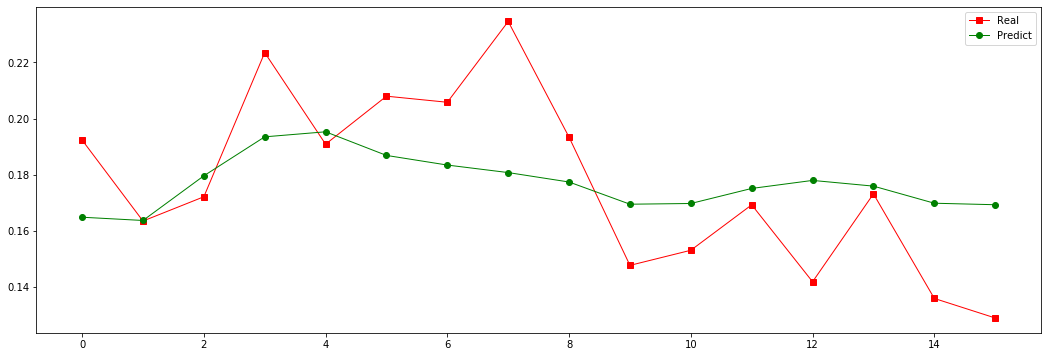

In [34]:
t = np.arange(len(predict_train_y[4]))
plt.figure(figsize=(18,6))
plt.plot(t, train_y[40],"rs-", linewidth=1, label='Real')
plt.plot(t, predict_train_y[40], 'go-', linewidth=1, label='Predict')
plt.legend()
plt.show()


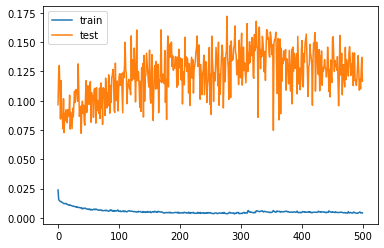

In [35]:
# 绘制历史数据
plt.plot(thismodel.history['loss'], label='train')
plt.plot(thismodel.history['val_loss'], label='test')
# plt.title(f'Epochs={epoch_num}, Batch_size={batch_size},Ahead=400')
# plt.savefig(f'compare/{n}.png')
plt.legend()
plt.show()


In [36]:
#用第13天的数据检查模型的效果
datanew = data.iloc[2*2800:3*2800]
datanew

,speed,power
date,,
2015-10-02 22:40:00,0.32892,0.21068
2015-10-02 22:40:30,0.33020,0.20591
2015-10-02 22:41:00,0.32984,0.20333
2015-10-02 22:41:30,0.32992,0.20022
2015-10-02 22:42:00,0.32924,0.19858
...,...,...
2015-10-03 21:57:30,0.55300,0.95269
2015-10-03 21:58:00,0.55478,0.93415
2015-10-03 21:58:30,0.55565,0.93431


In [37]:
values = datanew.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [38]:
values = reframed.values
# train = values[:n_train_hours, :]
n_obs = n_back * n_feature
Real_X, Real_y = values[:, :n_obs], train[:, -n_out:]
Real_X


array([[0.32892, 0.21068, 0.3302 , ..., 0.66999, 0.46509, 0.65737],
       [0.3302 , 0.20591, 0.32984, ..., 0.65737, 0.46609, 0.65367],
       [0.32984, 0.20333, 0.32992, ..., 0.65367, 0.46702, 0.65565],
       ...,
       [0.38162, 0.36657, 0.38366, ..., 0.62666, 0.45795, 0.60558],
       [0.38366, 0.38076, 0.38431, ..., 0.60558, 0.46011, 0.63367],
       [0.38431, 0.36915, 0.38509, ..., 0.63367, 0.46197, 0.62875]],
      dtype=float32)

In [39]:
y_test_predict=model.predict(Real_X)
y_test_predict

61/61 [==============================] - 0s 4ms/step


array([[0.58313113, 0.61129034, 0.6665143 , ..., 0.75006974, 0.73680896,
        0.72513616],
       [0.58321375, 0.6115199 , 0.6668545 , ..., 0.7500478 , 0.73707205,
        0.7257252 ],
       [0.5831268 , 0.611531  , 0.6669264 , ..., 0.74996483, 0.7371344 ,
        0.72598183],
       ...,
       [0.5865803 , 0.62163746, 0.6834998 , ..., 0.916075  , 0.9155386 ,
        0.91170645],
       [0.58693254, 0.6221378 , 0.6839273 , ..., 0.91480315, 0.91436654,
        0.91064584],
       [0.58698136, 0.6223916 , 0.68398863, ..., 0.91224277, 0.9120433 ,
        0.90839064]], dtype=float32)

In [40]:
Real_y

array([[0.17272, 0.19739, 0.13458, ..., 0.15887, 0.16167, 0.13977],
       [0.18162, 0.19278, 0.13499, ..., 0.15213, 0.15729, 0.14233],
       [0.17924, 0.192  , 0.13607, ..., 0.15656, 0.15294, 0.14763],
       ...,
       [0.81056, 0.82129, 0.83603, ..., 0.92092, 0.95008, 0.95214],
       [0.77787, 0.82557, 0.83631, ..., 0.91911, 0.93664, 0.97586],
       [0.78396, 0.84234, 0.82731, ..., 0.89689, 0.93764, 0.93915]],
      dtype=float32)

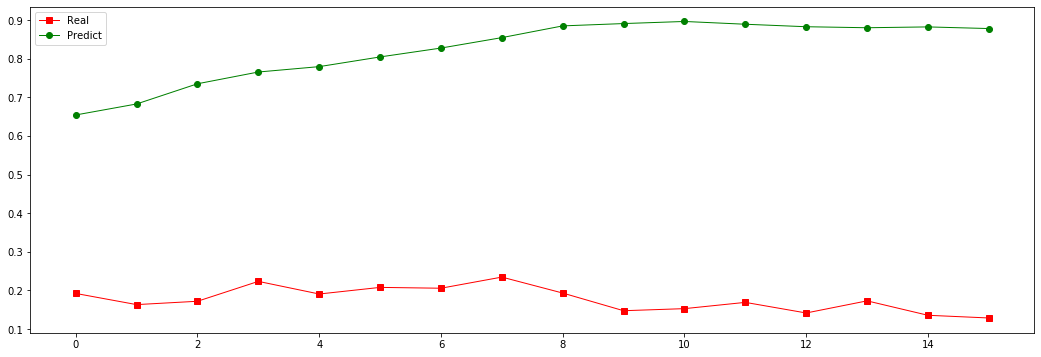

In [41]:

t = np.arange(len(y_test_predict[4]))
plt.figure(figsize=(18,6))
plt.plot(t, Real_y[40],"rs-", linewidth=1, label='Real')
plt.plot(t, y_test_predict[40], 'go-', linewidth=1, label='Predict')
plt.legend()
plt.show()


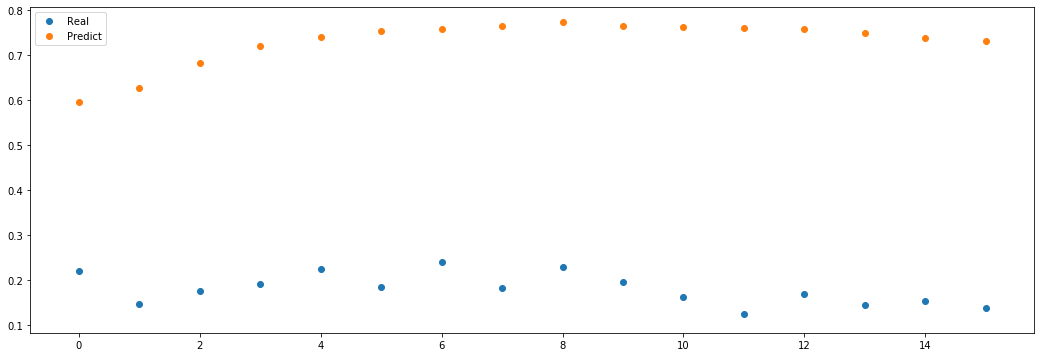

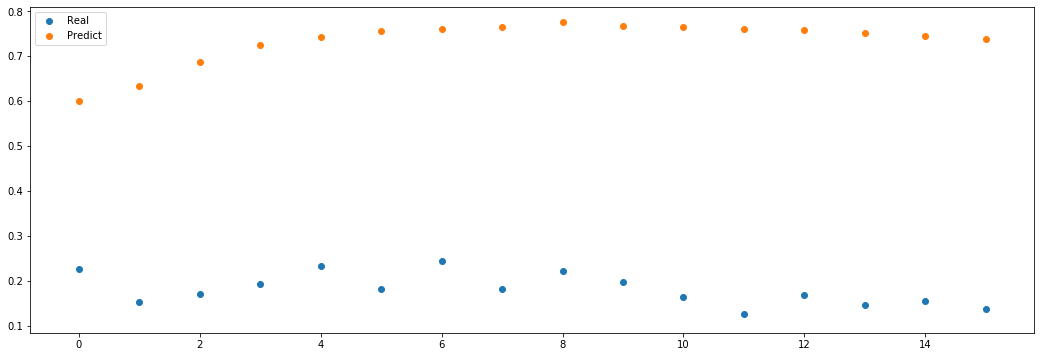

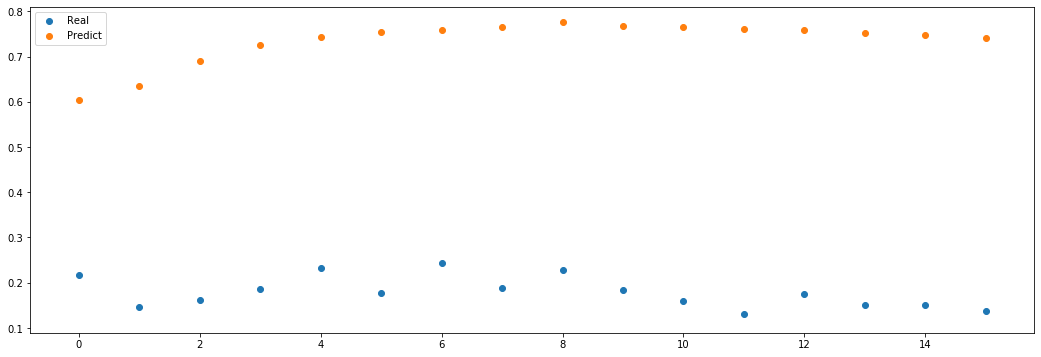

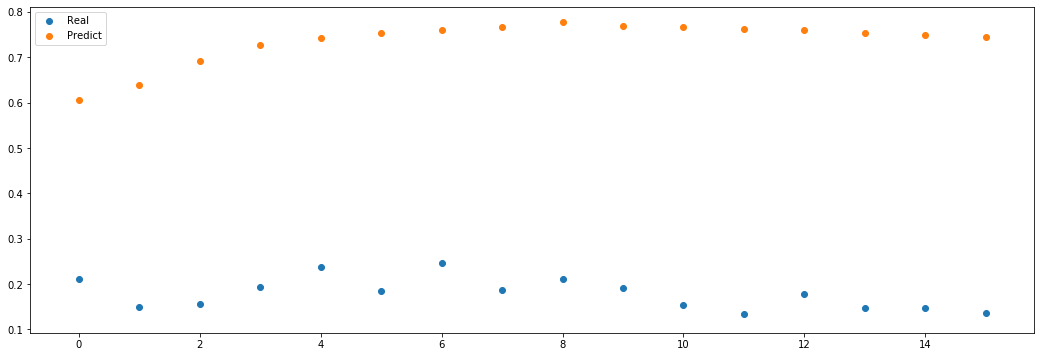

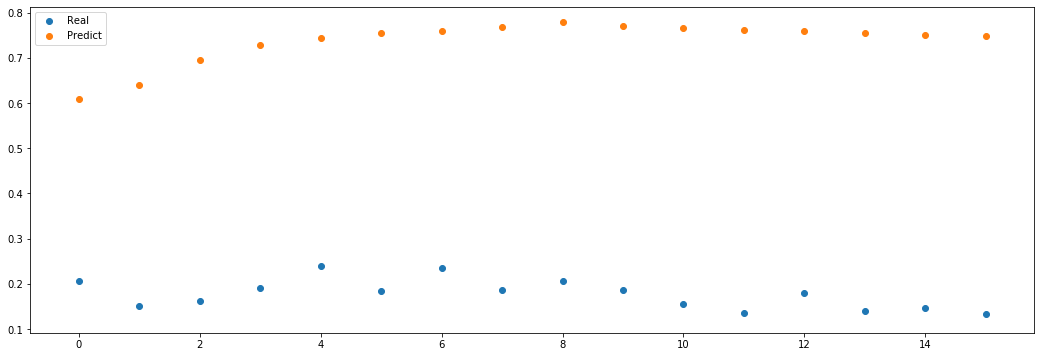

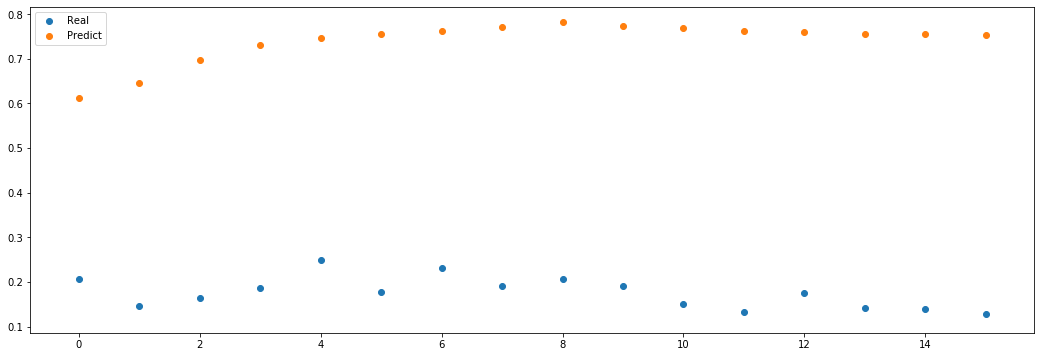

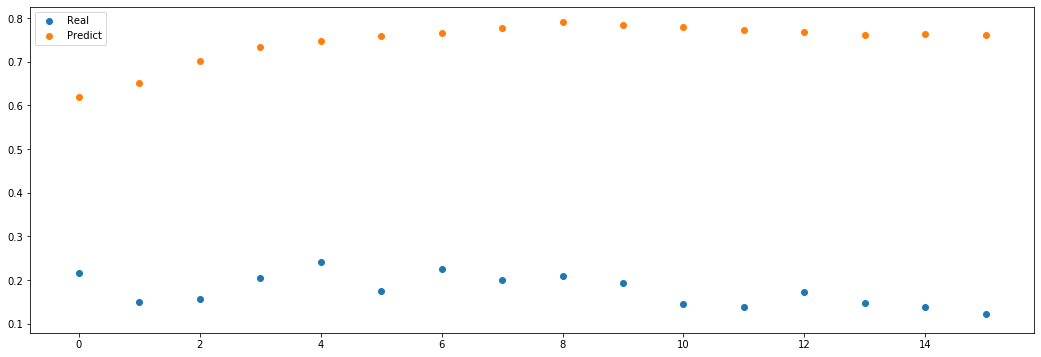

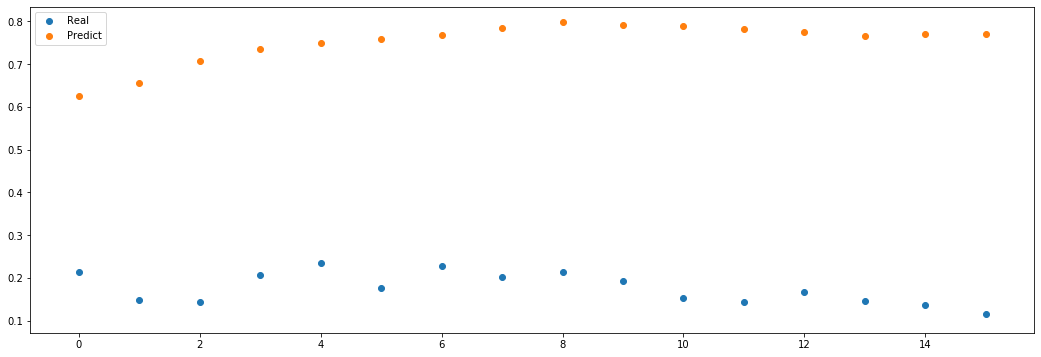

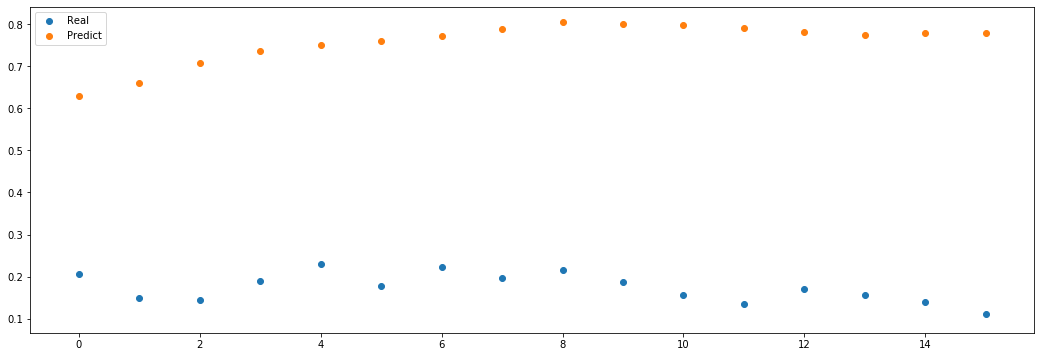

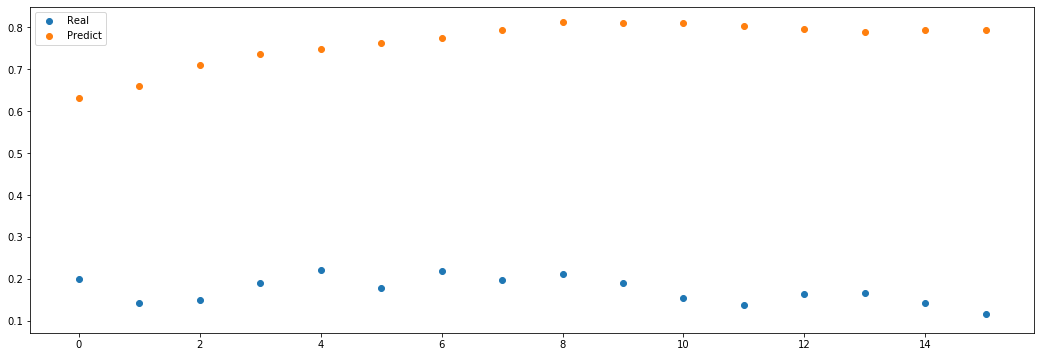

In [42]:
for i in range(20,30):
    t = np.arange(len(y_test_predict[i*16]))
    plt.figure(figsize=(18,6))
    # plt.plot(t, y_test_true[i*60],"rs-", linewidth=1, label='Real')
    plt.scatter(t, Real_y[i], label='Real')
    # plt.plot(t, y_test_predict[i*60], 'go-', linewidth=1, label='Predict')
    plt.scatter(t, y_test_predict[i], label='Predict')

    plt.legend()
    plt.show()